In [1]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

In [2]:
def getDisparity(image_left, image_right):
    
    window_size = 9
    min_disp = -21
    num_disp = 96
    
#     sbm.SADWindowSize = 9;
#     sbm.numberOfDisparities = 96;
#     sbm.preFilterCap = 63;
#     sbm.minDisparity = -21;
#     sbm.uniquenessRatio = 7;
#     sbm.speckleWindowSize = 0;
#     sbm.speckleRange = 8;
#     sbm.disp12MaxDiff = 1;
#     sbm.fullDP = False;

    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        disp12MaxDiff = 1,
        uniquenessRatio = 7,
        speckleWindowSize = 0,
        speckleRange = 8
        )
    
    disparity = stereo.compute(image_left, image_right).astype(np.float32) / 16.0
    disparity = (disparity-min_disp)/num_disp
    
    return disparity

In [3]:
def getPoses():
    poses = []
    with open("poses.txt","r") as f:
        lines = f.readlines()
        for line in lines:
            row = line.split(" ")
            row = np.array(row).astype('float64')
            poses.append(row.reshape((3, 4)))
    return poses

In [4]:
def project_points(points, colors, K, P, width, height):
    R = P[:, :3]
    t = P[:, 3]
    dist_coeff = np.zeros((4, 1))
    projected, _ = cv2.projectPoints(points, R, t, K, dist_coeff)
    print(projected.shape)
    xy = projected.reshape(-1, 2).astype(np.int)
#     print(xy.shape)
    mask = (
        (0 <= xy[:, 0]) & (xy[:, 0] < width) &
        (0 <= xy[:, 1]) & (xy[:, 1] < height)
    )
    return xy[mask], colors[mask]

In [5]:
def getImage(points, color, height, width):
    image = np.zeros((height, width, 3), dtype=color.dtype)
    image[points[:, 1], points[:, 0]] = color
    return image

(370, 1226)


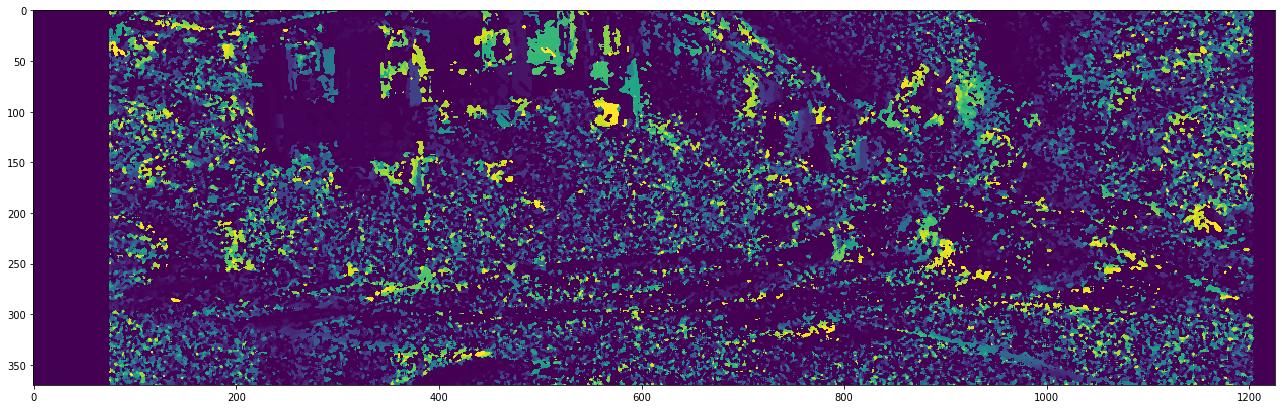

In [6]:
image_left = cv2.imread('img2/0000000460.png')
image_right = cv2.imread('img2/0000000461.png')

disparity = getDisparity(image_left, image_right)

w = disparity.shape[0]
l = disparity.shape[1]

print(disparity.shape)
plt.subplots_adjust(right=3, top=3)
plt.imshow(disparity)
plt.show()

(219131, 1, 2)
(212354, 1, 2)
(214401, 1, 2)
(213714, 1, 2)
(211039, 1, 2)
(209715, 1, 2)
(208079, 1, 2)
(212824, 1, 2)
(214020, 1, 2)
(216130, 1, 2)
(215666, 1, 2)
(215639, 1, 2)
(206902, 1, 2)
(211211, 1, 2)
(211096, 1, 2)
(218822, 1, 2)
(220083, 1, 2)
(209745, 1, 2)
(211773, 1, 2)
(223902, 1, 2)


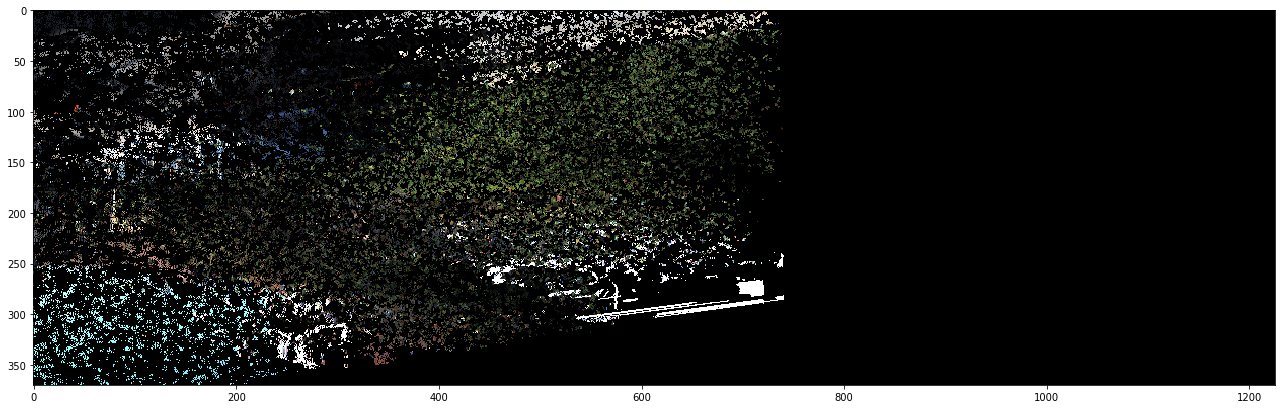

In [11]:
focal_length = 7.070912e+02
baseline = 0.53790448812
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02], [0.000000e+00, 7.070912e+02, 1.831104e+02], [0.000000e+00, 0.000000e+00, 1.000000e+00]])
poses = getPoses()

Q = np.array([
        [1, 0, 0, -l/2],
        [0, 1, 0, -w/2],
        [0, 0, 0, focal_length],
        [0, 0, -1/baseline, 0]
    ])

for i in range(460, 480):
    image_left = cv2.imread('img2/0000000{}.png'.format(i))
    image_right = cv2.imread('img2/0000000{}.png'.format(i+1))

    disparity = getDisparity(image_left, image_right)
    points_3D = cv2.reprojectImageTo3D(disparity, Q)

    mask_map = disparity > disparity.min()

    colors = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)

    output_points = points_3D[mask_map]
    output_colors = colors[mask_map]
    
    projected_points, color = project_points(output_points, output_colors, K, poses[i-460], l, w)
    cv2.imwrite("img" + str(i) + ".png", img)
    img = getImage(projected_points, color, w, l)
    plt.subplots_adjust(right=3, top=3)
    plt.imshow(img)

    plt.plot()
